# Hybrid of Resampling and Cost Sensitive Methods

In [2]:
from imblearn.combine import SMOTEENN, SMOTETomek

sklearn reference에서는 SMOTE ENN이 Noisy 제거에 SMOTETomek 보다 나은 결과를 제시한다고 말하고 있음

In [46]:
def sampling_smote_enn(x_input, y_input, smote=None, enn=None, sampling_strategy='auto'):
    """
    :param x_input: x data 입력
    :param y_input: y data 입력
    :param smote: SMOTE 객체 입력
    :param enn: ENN 객체 입력
    :param sampling_strategy: 딕셔너리 구조로 입력
    :return: x_sme, y_sme
    """
    import pandas as pd
    from imblearn.combine import SMOTEENN
    sme = SMOTEENN(smote=smote,
                   enn=enn,
                   sampling_strategy=sampling_strategy,
                   random_state=42,
                   n_jobs=-1)

    x_sme, y_sme = sme.fit_resample(x_input, y_input)

    print("Before SMOTE ENN....")
    print("The shape of your X data: ", x_input.shape)
    print("The shape of your y data: ", y_input.shape)
    print("Label Counts : \n", pd.Series(y_input).value_counts().sort_index())
    print('\n')
    print("After SMOTE ENN Applied....")
    print("The shape of your X_SME data: ", x_sme.shape)
    print("The shape of your y_SME data: ", y_sme.shape)
    print("Label Counts : \n", pd.Series(y_sme).value_counts().sort_index())

    return x_sme, y_sme

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [6]:
dfs = pd.read_csv('./processed.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
train.shape, test.shape

((75000, 23), (25000, 23))

In [7]:
le = LabelEncoder()
dfs['Month'] = le.fit_transform(dfs['Month'])
train['Month'] = le.transform(train['Month'])
test['Month'] = le.transform(test['Month'])

In [8]:
target = 'Credit_Score'
cat_col = ['Customer_ID', 'Month', 'Credit_Mix', 'Credit_History_Age',
           'Payment_of_Min_Amount', 'Payment_Behaviour']
cat_dims = {}
for col in cat_col:
    cat_dims[col] = len(list(dfs[col].unique()))
    print(col, ': ', cat_dims[col])
cat_col_idx = [list(dfs.columns).index(col) for col in cat_col]
cat_col_dims = [cat_dims[col] for col in cat_col]
all_col_list = [col for col in dfs.columns if col !=target]

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Payment_of_Min_Amount :  3
Payment_Behaviour :  6


In [9]:
x_train = train.loc[:, all_col_list].values
y_train = train.loc[:, target].values
x_test = test.loc[:, all_col_list].values
y_test = test.loc[:, target].values

In [13]:
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks

In [14]:
enn = EditedNearestNeighbours(n_jobs=-1)

In [20]:
smoteenn = SMOTEENN(smote=SMOTE(),
                    enn=enn,
                    random_state=42,
                    n_jobs=-1)

In [21]:
x_sme, y_sme = smoteenn.fit_resample(x_train, y_train)

In [42]:
pd.Series(y_sme).value_counts()

0    40214
2    31570
1    15637
dtype: int64

In [22]:
x_sme.shape

(87421, 21)

In [23]:
y_sme.shape

(87421,)

In [24]:
from sklearn.ensemble import RandomForestClassifier

In [25]:
rfc = RandomForestClassifier(n_jobs=-1, random_state=42)

In [26]:
rfc.fit(x_sme, y_sme)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [27]:
rfc.score(x_test, y_test)

0.6858

In [32]:
from sklearn.metrics import classification_report, plot_confusion_matrix

In [29]:
y_pred = rfc.predict(x_test)

In [31]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.65      0.86      0.74      7216
           1       0.80      0.57      0.67     12960
           2       0.58      0.74      0.65      4824

    accuracy                           0.69     25000
   macro avg       0.67      0.72      0.68     25000
weighted avg       0.71      0.69      0.68     25000



/Users/ben/miniforge3/envs/tf_mini/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


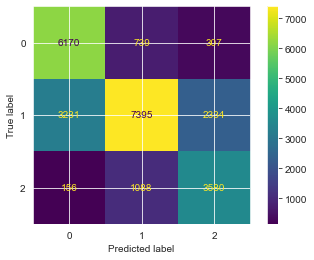

In [38]:
plot_confusion_matrix(y_true=y_test, X=x_test, estimator=rfc)

In [49]:
smote = SMOTE(k_neighbors=7)

In [50]:
x_sme, y_sme = sampling_smote_enn(x_train, y_train, smote=smote, enn=None, sampling_strategy='auto')

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (72981, 21)
The shape of your y_SME data:  (72981,)
Label Counts : 
 0    27039
1    15275
2    30667
dtype: int64


지금 ENN으로 너무 많은 다수 데이터를 제거한 것으로 보임. 정보 유실이 심각하게 우려됨

In [51]:
x_sme, y_sme = sampling_smote_enn(x_train, y_train, sampling_strategy='auto')

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (74703, 21)
The shape of your y_SME data:  (74703,)
Label Counts : 
 0    27507
1    15619
2    31577
dtype: int64


In [52]:
from sklearn.utils.class_weight import compute_class_weight

In [54]:
weights = compute_class_weight(class_weight = "balanced" ,
                               classes=np.unique(y_sme),
                               y = y_sme)

weights

array([0.90526048, 1.5942762 , 0.7885803 ])

In [57]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

In [58]:
rfc.fit(x_sme, y_sme)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [59]:
rfc.score(x_sme, y_sme)

0.9999866136567473

In [60]:
rfc.score(x_test, y_test)

0.67392

In [61]:
y_pred = rfc.predict(x_test)

In [62]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.67      0.77      0.71      7216
           1       0.78      0.60      0.67     12960
           2       0.53      0.75      0.62      4824

    accuracy                           0.67     25000
   macro avg       0.66      0.70      0.67     25000
weighted avg       0.70      0.67      0.68     25000



In [65]:
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer
from pytorch_tabnet.metrics import Metric
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix

In [66]:
class F1_Score(Metric):
    def __init__(self):
        self._name = 'f1'
        self._maximize = True

    def __call__(self, y_true, y_score):
        score = f1_score(y_true, (y_score[:, 1]>0.5)*1, average='micro')
        return score

In [67]:
target = 'Credit_Score'
cat_col = ['Customer_ID', 'Month', 'Credit_Mix', 'Credit_History_Age',
           'Payment_of_Min_Amount', 'Payment_Behaviour']
cat_dims = {}
for col in cat_col:
    cat_dims[col] = len(list(dfs[col].unique()))
    print(col, ': ', cat_dims[col])
cat_col_idx = [list(dfs.columns).index(col) for col in cat_col]
cat_col_dims = [cat_dims[col] for col in cat_col]
all_col_list = [col for col in dfs.columns if col !=target]

Customer_ID :  12500
Month :  8
Credit_Mix :  3
Credit_History_Age :  2
Payment_of_Min_Amount :  3
Payment_Behaviour :  6


In [68]:
x_train = train.loc[:, all_col_list].values
y_train = train.loc[:, target].values
x_test = test.loc[:, all_col_list].values
y_test = test.loc[:, target].values

In [70]:
x_sme, y_sme = sampling_smote_enn(x_train, y_train)

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (74703, 21)
The shape of your y_SME data:  (74703,)
Label Counts : 
 0    27507
1    15619
2    31577
dtype: int64


In [71]:
from sklearn.utils.class_weight import compute_class_weight

In [72]:
weights = compute_class_weight(class_weight = "balanced" ,
                               classes=np.unique(y_sme),
                               y = y_sme)

weights

array([0.90526048, 1.5942762 , 0.7885803 ])

In [73]:
# pretrain model
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5*1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=x_sme,
    max_epochs=90,
    drop_last=False,
    pretraining_ratio=0.6, #0.5
)

reconstructed_X, embedded_X = unsupervised_model.predict(x_sme)
assert(reconstructed_X.shape == embedded_X.shape)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 4.34643 |  0:00:15s
epoch 1  | loss: 2.27185 |  0:00:30s
epoch 2  | loss: 1.75736 |  0:00:46s
epoch 3  | loss: 1.39725 |  0:01:00s
epoch 4  | loss: 1.2126  |  0:01:16s
epoch 5  | loss: 1.07706 |  0:01:34s
epoch 6  | loss: 1.04188 |  0:01:50s
epoch 7  | loss: 1.02312 |  0:02:11s
epoch 8  | loss: 1.01316 |  0:02:30s
epoch 9  | loss: 0.99287 |  0:02:46s
epoch 10 | loss: 0.97379 |  0:03:00s
epoch 11 | loss: 0.96142 |  0:03:15s
epoch 12 | loss: 0.95093 |  0:03:29s
epoch 13 | loss: 0.94367 |  0:03:43s
epoch 14 | loss: 0.93977 |  0:03:54s
epoch 15 | loss: 0.93543 |  0:04:06s
epoch 16 | loss: 0.93248 |  0:04:17s
epoch 17 | loss: 0.93146 |  0:04:29s
epoch 18 | loss: 0.92711 |  0:04:41s
epoch 19 | loss: 0.92042 |  0:04:52s
epoch 20 | loss: 0.91453 |  0:05:04s
epoch 21 | loss: 0.90979 |  0:05:15s
epoch 22 | loss: 0.90661 |  0:05:27s
epoch 23 | loss: 0.90376 |  0:05:38s
epoch 24 | loss: 0.90

In [74]:
model = TabNetClassifier(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='sparsemax',
    gamma=1.3,
    )

Device used : cpu


In [75]:
model.fit(
    X_train=x_sme,
    y_train=y_sme,
    eval_set=[(x_sme, y_sme)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=1,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 8.20009 | train_balanced_accuracy: 0.53951 | train_accuracy: 0.48194 |  0:00:13s
epoch 1  | loss: 0.95942 | train_balanced_accuracy: 0.77918 | train_accuracy: 0.79929 |  0:00:26s
epoch 2  | loss: 0.5735  | train_balanced_accuracy: 0.80897 | train_accuracy: 0.82938 |  0:00:39s
epoch 3  | loss: 0.51206 | train_balanced_accuracy: 0.82426 | train_accuracy: 0.84347 |  0:00:52s
epoch 4  | loss: 0.47766 | train_balanced_accuracy: 0.83502 | train_accuracy: 0.84821 |  0:01:06s
epoch 5  | loss: 0.45106 | train_balanced_accuracy: 0.84558 | train_accuracy: 0.85871 |  0:01:20s
epoch 6  | loss: 0.4212  | train_balanced_accuracy: 0.86022 | train_accuracy: 0.87141 |  0:01:33s
epoch 7  | loss: 0.39833 | train_balanced_accuracy: 0.87033 | train_accuracy: 0.87577 |  0:01:46s
epoch 8  | loss: 0.37164 | train_balanced_accuracy: 0.87722 | train_accuracy: 0.88573 |  0:02:00s
epoch 9  | loss: 0.35253 | train_balanced_accuracy: 0.88821 | train_accu

#### Result

In [76]:
from sklearn.metrics import classification_report

In [77]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.44
Month :  0.098
Age :  0.0
Monthly_Inhand_Salary :  0.002
Num_Bank_Accounts :  0.031
Num_Credit_Card :  0.036
Interest_Rate :  0.036
Num_of_Loan :  0.021
Delay_from_due_date :  0.043
Num_of_Delayed_Payment :  0.003
Changed_Credit_Limit :  0.003
Num_Credit_Inquiries :  0.024
Credit_Mix :  0.065
Outstanding_Debt :  0.055
Credit_Utilization_Ratio :  0.003
Credit_History_Age :  0.014
Payment_of_Min_Amount :  0.011
Total_EMI_per_month :  0.019
Amount_invested_monthly :  0.014
Payment_Behaviour :  0.044
Monthly_Balance :  0.036


In [78]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.75      0.90      0.82     21782
           1       0.95      0.71      0.81     40214
           2       0.65      0.94      0.77     13004

    accuracy                           0.80     75000
   macro avg       0.78      0.85      0.80     75000
weighted avg       0.84      0.80      0.81     75000



In [26]:
# f1_score(y_train, (model.predict(x_train)))

In [79]:
predicted = model.predict(x_test)

In [80]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.6480747897150249
0.64336


In [81]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      7216
           1       0.77      0.57      0.65     12960
           2       0.46      0.74      0.57      4824

    accuracy                           0.64     25000
   macro avg       0.63      0.67      0.64     25000
weighted avg       0.68      0.64      0.65     25000



In [82]:
print(confusion_matrix(y_test, predicted))

[[5148 1064 1004]
 [2403 7353 3204]
 [ 108 1133 3583]]


class weight 부여 후 0과 2클래스에 대해 더 많이 맞췄음.

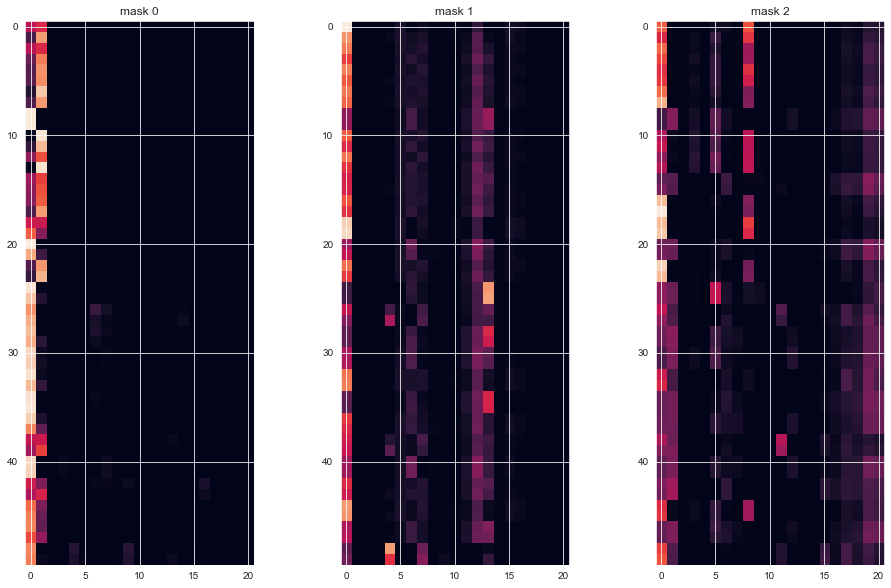

In [83]:
explain_matrix, masks = model.explain(x_test)

fig, axs = plt.subplots(1, 3, figsize=(16,10))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

Without Class_weights

In [84]:
model.fit(
    X_train=x_sme,
    y_train=y_sme,
    eval_set=[(x_sme, y_sme)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=0,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 1.65824 | train_balanced_accuracy: 0.72305 | train_accuracy: 0.7804  |  0:00:15s
epoch 1  | loss: 0.53688 | train_balanced_accuracy: 0.80609 | train_accuracy: 0.83844 |  0:00:28s
epoch 2  | loss: 0.48049 | train_balanced_accuracy: 0.81825 | train_accuracy: 0.84699 |  0:00:43s
epoch 3  | loss: 0.45191 | train_balanced_accuracy: 0.82259 | train_accuracy: 0.85121 |  0:00:56s
epoch 4  | loss: 0.43172 | train_balanced_accuracy: 0.82547 | train_accuracy: 0.85588 |  0:01:09s
epoch 5  | loss: 0.41822 | train_balanced_accuracy: 0.83181 | train_accuracy: 0.86069 |  0:01:23s
epoch 6  | loss: 0.40101 | train_balanced_accuracy: 0.84289 | train_accuracy: 0.86568 |  0:01:37s
epoch 7  | loss: 0.38077 | train_balanced_accuracy: 0.8509  | train_accuracy: 0.87469 |  0:01:52s
epoch 8  | loss: 0.36028 | train_balanced_accuracy: 0.86479 | train_accuracy: 0.88255 |  0:02:06s
epoch 9  | loss: 0.33792 | train_balanced_accuracy: 0.87432 | train_accu

#### Result

In [85]:
from sklearn.metrics import classification_report

In [86]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.564
Month :  0.066
Age :  0.0
Monthly_Inhand_Salary :  0.0
Num_Bank_Accounts :  0.019
Num_Credit_Card :  0.04
Interest_Rate :  0.016
Num_of_Loan :  0.014
Delay_from_due_date :  0.041
Num_of_Delayed_Payment :  0.0
Changed_Credit_Limit :  0.007
Num_Credit_Inquiries :  0.017
Credit_Mix :  0.068
Outstanding_Debt :  0.031
Credit_Utilization_Ratio :  0.0
Credit_History_Age :  0.018
Payment_of_Min_Amount :  0.016
Total_EMI_per_month :  0.004
Amount_invested_monthly :  0.001
Payment_Behaviour :  0.048
Monthly_Balance :  0.028


In [87]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83     21782
           1       0.95      0.72      0.82     40214
           2       0.67      0.95      0.79     13004

    accuracy                           0.81     75000
   macro avg       0.79      0.86      0.81     75000
weighted avg       0.85      0.81      0.82     75000



In [88]:
# f1_score(y_train, (model.predict(x_train)))

In [89]:
predicted = model.predict(x_test)

In [90]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.6586681611336666
0.65592


In [91]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69      7216
           1       0.75      0.60      0.66     12960
           2       0.51      0.74      0.60      4824

    accuracy                           0.66     25000
   macro avg       0.64      0.68      0.65     25000
weighted avg       0.68      0.66      0.66     25000



In [92]:
print(confusion_matrix(y_test, predicted))

[[5058 1464  694]
 [2388 7753 2819]
 [  95 1142 3587]]


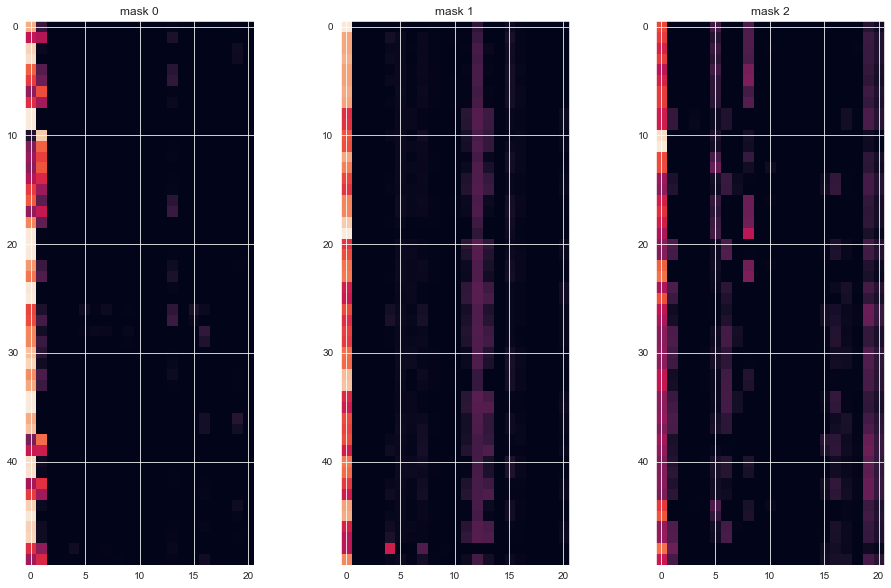

In [93]:
explain_matrix, masks = model.explain(x_test)

fig, axs = plt.subplots(1, 3, figsize=(16,10))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [94]:
pd.Series(y_train).value_counts()

1    40214
0    21782
2    13004
dtype: int64

위에서는 ENN으로 다수 데이터를 약 2만3천여개 줄였음. 정보의 유실이 많은 상태였음. 이번엔 유실을 완화시켜보도록 함

In [95]:
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1) # less conservative

In [96]:
x_sme, y_sme = sampling_smote_enn(x_train, y_train, smote=smote, enn=enn)

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (102463, 21)
The shape of your y_SME data:  (102463,)
Label Counts : 
 0    40214
1    24534
2    37715
dtype: int64


In [98]:
# pretrain model
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5*1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=x_sme,
    max_epochs=90,
    drop_last=False,
    pretraining_ratio=0.6, #0.5
)

reconstructed_X, embedded_X = unsupervised_model.predict(x_sme)
assert(reconstructed_X.shape == embedded_X.shape)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 3.91526 |  0:00:23s
epoch 1  | loss: 1.9489  |  0:00:44s
epoch 2  | loss: 1.42341 |  0:01:06s
epoch 3  | loss: 1.1632  |  0:01:27s
epoch 4  | loss: 1.05293 |  0:01:48s
epoch 5  | loss: 1.02697 |  0:02:11s
epoch 6  | loss: 1.00979 |  0:02:30s
epoch 7  | loss: 0.98161 |  0:02:46s
epoch 8  | loss: 0.96538 |  0:03:05s
epoch 9  | loss: 0.95332 |  0:03:22s
epoch 10 | loss: 0.94659 |  0:03:41s
epoch 11 | loss: 0.94321 |  0:03:59s
epoch 12 | loss: 0.94056 |  0:04:17s
epoch 13 | loss: 0.93409 |  0:04:36s
epoch 14 | loss: 0.92628 |  0:04:55s
epoch 15 | loss: 0.91971 |  0:05:13s
epoch 16 | loss: 0.9158  |  0:05:32s
epoch 17 | loss: 0.90947 |  0:05:50s
epoch 18 | loss: 0.90306 |  0:06:08s
epoch 19 | loss: 0.8995  |  0:06:26s
epoch 20 | loss: 0.89703 |  0:06:45s
epoch 21 | loss: 0.89356 |  0:07:03s
epoch 22 | loss: 0.89233 |  0:07:21s
epoch 23 | loss: 0.89017 |  0:07:39s
epoch 24 | loss: 0.88

In [99]:
model = TabNetClassifier(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='sparsemax',
    gamma=1.3,
    )

Device used : cpu


In [100]:
model.fit(
    X_train=x_sme,
    y_train=y_sme,
    eval_set=[(x_sme, y_sme)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=0,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 7.49411 | train_balanced_accuracy: 0.70359 | train_accuracy: 0.7331  |  0:00:16s
epoch 1  | loss: 0.62062 | train_balanced_accuracy: 0.77657 | train_accuracy: 0.7932  |  0:00:36s
epoch 2  | loss: 0.54972 | train_balanced_accuracy: 0.79289 | train_accuracy: 0.80897 |  0:00:53s
epoch 3  | loss: 0.51511 | train_balanced_accuracy: 0.81757 | train_accuracy: 0.82387 |  0:01:11s
epoch 4  | loss: 0.47502 | train_balanced_accuracy: 0.8397  | train_accuracy: 0.84361 |  0:01:29s
epoch 5  | loss: 0.4271  | train_balanced_accuracy: 0.86141 | train_accuracy: 0.86435 |  0:01:46s
epoch 6  | loss: 0.38243 | train_balanced_accuracy: 0.87318 | train_accuracy: 0.87884 |  0:02:04s
epoch 7  | loss: 0.3388  | train_balanced_accuracy: 0.8939  | train_accuracy: 0.89846 |  0:02:21s
epoch 8  | loss: 0.30274 | train_balanced_accuracy: 0.90866 | train_accuracy: 0.91064 |  0:02:40s
epoch 9  | loss: 0.27768 | train_balanced_accuracy: 0.91241 | train_accu

#### Result

In [101]:
from sklearn.metrics import classification_report

In [102]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.383
Month :  0.025
Age :  0.026
Monthly_Inhand_Salary :  0.123
Num_Bank_Accounts :  0.021
Num_Credit_Card :  0.025
Interest_Rate :  0.061
Num_of_Loan :  0.034
Delay_from_due_date :  0.085
Num_of_Delayed_Payment :  0.025
Changed_Credit_Limit :  0.004
Num_Credit_Inquiries :  0.028
Credit_Mix :  0.002
Outstanding_Debt :  0.05
Credit_Utilization_Ratio :  0.001
Credit_History_Age :  0.072
Payment_of_Min_Amount :  0.006
Total_EMI_per_month :  0.008
Amount_invested_monthly :  0.0
Payment_Behaviour :  0.018
Monthly_Balance :  0.003


In [103]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.81      0.99      0.89     21782
           1       0.99      0.78      0.87     40214
           2       0.78      0.98      0.87     13004

    accuracy                           0.88     75000
   macro avg       0.86      0.92      0.88     75000
weighted avg       0.90      0.88      0.88     75000



In [104]:
# f1_score(y_train, (model.predict(x_train)))

In [105]:
predicted = model.predict(x_test)

In [106]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.7274581696255983
0.72888


In [107]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.69      0.86      0.76      7216
           1       0.79      0.66      0.72     12960
           2       0.67      0.73      0.70      4824

    accuracy                           0.73     25000
   macro avg       0.72      0.75      0.73     25000
weighted avg       0.74      0.73      0.73     25000



기존 대비 0번 클래스를 더 잘맞추나, 2번 클래스에 대한 전반적인 성능은 줄었음

In [108]:
print(confusion_matrix(y_test, predicted))

[[6179 1006   31]
 [2736 8527 1697]
 [  56 1252 3516]]


### Scaler

In [113]:
train

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,576,0,3,12,7.509249,3.0,4.0,3.0,0,3.0,...,2,28.460148,26.822620,1,1,49.574949,21.465380,2,312.494089,2
1,576,1,3,12,7.509249,3.0,4.0,3.0,0,3.0,...,2,28.460148,31.944960,1,1,49.574949,21.465380,3,284.629162,2
2,576,2,3,12,7.509249,3.0,4.0,3.0,0,3.0,...,2,28.460148,28.609352,1,1,49.574949,21.465380,4,331.209863,2
3,576,3,3,12,7.509249,3.0,4.0,3.0,0,5.0,...,2,28.460148,31.377862,1,1,49.574949,21.465380,5,223.451310,2
4,576,4,3,12,7.509249,3.0,4.0,3.0,0,6.0,...,2,28.460148,24.797347,1,1,49.574949,21.465380,1,341.489231,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,9254,1,3,9,8.119522,4.0,6.0,7.0,0,23.0,...,2,22.413835,29.135447,1,1,35.104023,24.028477,4,400.104466,1
74996,9254,2,3,9,8.119522,4.0,6.0,7.0,0,20.0,...,2,22.413835,39.323569,1,1,35.104023,24.028477,1,410.256158,0
74997,9254,3,3,9,8.119522,4.0,6.0,7.0,0,23.0,...,2,22.413835,34.663572,1,1,35.104023,24.028477,0,479.866228,0
74998,9254,4,3,9,8.119522,4.0,6.0,7.0,0,18.0,...,2,22.413835,40.565631,1,1,35.104023,24.028477,1,496.651610,0


In [114]:
from sklearn.preprocessing import RobustScaler

In [115]:
scaling_cols = ['Monthly_Inhand_Salary', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Total_EMI_per_month',
                'Amount_invested_monthly', 'Monthly_Balance']
rs = RobustScaler()

rs_train_df = train[scaling_cols].copy()
rs_test_df = test[scaling_cols].copy()

rs_train_df = rs.fit_transform(rs_train_df)
rs_test_df = rs.transform(rs_test_df)

train[scaling_cols] = rs_train_df
test[scaling_cols] = rs_test_df

In [116]:
train

,Customer_ID,Month,Age,Occupation,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,576,0,3,12,-0.407299,3.0,4.0,3.0,0,3.0,...,2,-0.279953,-0.648697,1,1,-0.139504,-0.546677,2,-0.108344,2
1,576,1,3,12,-0.407299,3.0,4.0,3.0,0,3.0,...,2,-0.279953,-0.041010,1,1,-0.139504,-0.546677,3,-0.250764,2
2,576,2,3,12,-0.407299,3.0,4.0,3.0,0,3.0,...,2,-0.279953,-0.436728,1,1,-0.139504,-0.546677,4,-0.012686,2
3,576,3,3,12,-0.407299,3.0,4.0,3.0,0,5.0,...,2,-0.279953,-0.108287,1,1,-0.139504,-0.546677,5,-0.563450,2
4,576,4,3,12,-0.407299,3.0,4.0,3.0,0,6.0,...,2,-0.279953,-0.888964,1,1,-0.139504,-0.546677,1,0.039852,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,9254,1,3,9,0.062676,4.0,6.0,7.0,0,23.0,...,2,-0.577496,-0.374315,1,1,-0.264438,-0.487533,4,0.339440,1
74996,9254,2,3,9,0.062676,4.0,6.0,7.0,0,20.0,...,2,-0.577496,0.834349,1,1,-0.264438,-0.487533,1,0.391326,0
74997,9254,3,3,9,0.062676,4.0,6.0,7.0,0,23.0,...,2,-0.577496,0.281512,1,1,-0.264438,-0.487533,0,0.747110,0
74998,9254,4,3,9,0.062676,4.0,6.0,7.0,0,18.0,...,2,-0.577496,0.981701,1,1,-0.264438,-0.487533,1,0.832901,0


In [117]:
x_train = train.loc[:, all_col_list].values
y_train = train.loc[:, target].values
x_test = test.loc[:, all_col_list].values
y_test = test.loc[:, target].values

In [118]:
x_sme, y_sme = sampling_smote_enn(x_train, y_train, smote=smote, enn=enn)

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (111776, 21)
The shape of your y_SME data:  (111776,)
Label Counts : 
 0    40214
1    32145
2    39417
dtype: int64


In [119]:
x_sme

array([[ 5.15400000e+03,  0.00000000e+00,  4.00000000e+00, ...,
        -3.65283721e-01,  3.00000000e+00, -1.81442738e-01],
       [ 5.15400000e+03,  1.00000000e+00,  4.00000000e+00, ...,
        -3.65283721e-01,  0.00000000e+00,  2.99020207e-01],
       [ 5.15400000e+03,  2.00000000e+00,  4.00000000e+00, ...,
        -3.65283721e-01,  3.00000000e+00, -3.71982890e-01],
       ...,
       [ 1.20400000e+03,  3.99286109e+00,  3.00000000e+00, ...,
        -4.48625139e-01,  4.66428703e+00, -4.89804132e-01],
       [ 6.03200000e+03,  2.79147460e+00,  5.00000000e+00, ...,
         7.62443094e-01,  2.81278811e+00,  1.22128162e-01],
       [ 7.83537651e+03,  3.62349488e+00,  3.37650512e+00, ...,
         5.66464894e-02,  2.37650512e+00,  6.34319339e-01]])

In [120]:
# pretrain model
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5*1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=x_sme,
    max_epochs=90,
    drop_last=False,
    pretraining_ratio=0.6, #0.5
)

reconstructed_X, embedded_X = unsupervised_model.predict(x_sme)
assert(reconstructed_X.shape == embedded_X.shape)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.92609 |  0:00:23s
epoch 1  | loss: 1.29888 |  0:00:46s
epoch 2  | loss: 1.05071 |  0:01:08s
epoch 3  | loss: 0.9612  |  0:01:29s
epoch 4  | loss: 0.91404 |  0:01:52s
epoch 5  | loss: 0.89945 |  0:02:16s
epoch 6  | loss: 0.88479 |  0:02:39s
epoch 7  | loss: 0.87487 |  0:03:03s
epoch 8  | loss: 0.86847 |  0:03:26s
epoch 9  | loss: 0.86599 |  0:03:59s
epoch 10 | loss: 0.86448 |  0:04:38s
epoch 11 | loss: 0.86372 |  0:05:18s
epoch 12 | loss: 0.86217 |  0:05:52s
epoch 13 | loss: 0.85986 |  0:06:23s
epoch 14 | loss: 0.85848 |  0:06:49s
epoch 15 | loss: 0.85799 |  0:07:12s
epoch 16 | loss: 0.856   |  0:07:50s
epoch 17 | loss: 0.85533 |  0:08:32s
epoch 18 | loss: 0.85386 |  0:09:15s
epoch 19 | loss: 0.85361 |  0:09:41s
epoch 20 | loss: 0.8538  |  0:10:00s
epoch 21 | loss: 0.85294 |  0:10:20s
epoch 22 | loss: 0.85188 |  0:10:41s
epoch 23 | loss: 0.85283 |  0:11:01s
epoch 24 | loss: 0.84

In [121]:
model = TabNetClassifier(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='sparsemax',
    gamma=1.3,
    )

Device used : cpu


In [122]:
model.fit(
    X_train=x_sme,
    y_train=y_sme,
    eval_set=[(x_sme, y_sme)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=0,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 1.23795 | train_balanced_accuracy: 0.77028 | train_accuracy: 0.77688 |  0:00:27s
epoch 1  | loss: 0.5744  | train_balanced_accuracy: 0.79475 | train_accuracy: 0.79874 |  0:00:52s
epoch 2  | loss: 0.50857 | train_balanced_accuracy: 0.84184 | train_accuracy: 0.84331 |  0:01:12s
epoch 3  | loss: 0.41715 | train_balanced_accuracy: 0.88141 | train_accuracy: 0.88328 |  0:01:31s
epoch 4  | loss: 0.32764 | train_balanced_accuracy: 0.91061 | train_accuracy: 0.91178 |  0:01:52s
epoch 5  | loss: 0.26425 | train_balanced_accuracy: 0.92638 | train_accuracy: 0.92691 |  0:02:11s
epoch 6  | loss: 0.22606 | train_balanced_accuracy: 0.93366 | train_accuracy: 0.9341  |  0:02:33s
epoch 7  | loss: 0.19932 | train_balanced_accuracy: 0.94148 | train_accuracy: 0.94203 |  0:02:52s
epoch 8  | loss: 0.18134 | train_balanced_accuracy: 0.9476  | train_accuracy: 0.94805 |  0:03:12s
epoch 9  | loss: 0.16534 | train_balanced_accuracy: 0.95118 | train_accu

#### Result

In [123]:
from sklearn.metrics import classification_report

In [124]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.783
Month :  0.02
Age :  0.0
Monthly_Inhand_Salary :  0.021
Num_Bank_Accounts :  0.002
Num_Credit_Card :  0.034
Interest_Rate :  0.012
Num_of_Loan :  0.005
Delay_from_due_date :  0.0
Num_of_Delayed_Payment :  0.004
Changed_Credit_Limit :  0.0
Num_Credit_Inquiries :  0.01
Credit_Mix :  0.051
Outstanding_Debt :  0.018
Credit_Utilization_Ratio :  0.0
Credit_History_Age :  0.003
Payment_of_Min_Amount :  0.021
Total_EMI_per_month :  0.003
Amount_invested_monthly :  0.002
Payment_Behaviour :  0.002
Monthly_Balance :  0.009


In [125]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.83      1.00      0.90     21782
           1       0.99      0.82      0.90     40214
           2       0.82      0.98      0.89     13004

    accuracy                           0.90     75000
   macro avg       0.88      0.93      0.90     75000
weighted avg       0.91      0.90      0.90     75000



In [126]:
# f1_score(y_train, (model.predict(x_train)))

In [127]:
predicted = model.predict(x_test)

In [128]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.7459952728392999
0.74704


In [129]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.71      0.86      0.78      7216
           1       0.81      0.68      0.74     12960
           2       0.69      0.77      0.73      4824

    accuracy                           0.75     25000
   macro avg       0.73      0.77      0.75     25000
weighted avg       0.76      0.75      0.75     25000



기존 대비 0번 클래스를 더 잘맞추나, 2번 클래스에 대한 전반적인 성능은 줄었음

In [130]:
print(confusion_matrix(y_test, predicted))

[[6181 1007   28]
 [2513 8768 1679]
 [  31 1066 3727]]


## SMOTE + Tomek

In [109]:
def sampling_smote_tomek(x_input, y_input, smote=None, tomek=None, sampling_strategy='auto'):
    """
    :param x_input: x data 입력
    :param y_input: y data 입력
    :param smote: SMOTE 객체 입력
    :param tomek: Tomek 객체 입력
    :param sampling_strategy: 딕셔너리 구조로 입력
    :return: x_smt, y_smt
    """
    import pandas as pd
    from imblearn.combine import SMOTETomek
    smt = SMOTETomek(smote=smote,
                   tomek=tomek,
                   sampling_strategy=sampling_strategy,
                   random_state=42,
                   n_jobs=-1)

    x_smt, y_smt = smt.fit_resample(x_input, y_input)

    print("Before SMOTE Tomek....")
    print("The shape of your X data: ", x_input.shape)
    print("The shape of your y data: ", y_input.shape)
    print("Label Counts : \n", pd.Series(y_input).value_counts().sort_index())
    print('\n')
    print("After SMOTE Tomek Applied....")
    print("The shape of your X_SME data: ", x_smt.shape)
    print("The shape of your y_SME data: ", y_smt.shape)
    print("Label Counts : \n", pd.Series(y_smt).value_counts().sort_index())

    return x_smt, y_smt

In [ ]:
from imblearn.combine import SMOTETomek

In [131]:
x_smt, y_smt = sampling_smote_tomek(x_train, y_train)

Before SMOTE Tomek....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE Tomek Applied....
The shape of your X_SME data:  (117826, 21)
The shape of your y_SME data:  (117826,)
Label Counts : 
 0    39140
1    38806
2    39880
dtype: int64


In [132]:
# pretrain model
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5*1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=x_smt,
    max_epochs=90,
    drop_last=False,
    pretraining_ratio=0.6, #0.5
)

reconstructed_X, embedded_X = unsupervised_model.predict(x_smt)
assert(reconstructed_X.shape == embedded_X.shape)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 1.89148 |  0:00:23s
epoch 1  | loss: 1.25966 |  0:00:43s
epoch 2  | loss: 1.04032 |  0:01:06s
epoch 3  | loss: 0.946   |  0:01:27s
epoch 4  | loss: 0.90628 |  0:01:49s
epoch 5  | loss: 0.89407 |  0:02:12s
epoch 6  | loss: 0.88076 |  0:02:35s
epoch 7  | loss: 0.87257 |  0:02:55s
epoch 8  | loss: 0.86935 |  0:03:19s
epoch 9  | loss: 0.86748 |  0:03:40s
epoch 10 | loss: 0.86619 |  0:04:01s
epoch 11 | loss: 0.86439 |  0:04:21s
epoch 12 | loss: 0.86199 |  0:04:42s
epoch 13 | loss: 0.8589  |  0:05:03s
epoch 14 | loss: 0.85741 |  0:05:24s
epoch 15 | loss: 0.85616 |  0:05:45s
epoch 16 | loss: 0.85427 |  0:06:06s
epoch 17 | loss: 0.85363 |  0:06:25s
epoch 18 | loss: 0.85188 |  0:06:45s
epoch 19 | loss: 0.85156 |  0:07:04s
epoch 20 | loss: 0.85061 |  0:07:23s
epoch 21 | loss: 0.84999 |  0:07:43s
epoch 22 | loss: 0.84998 |  0:08:02s
epoch 23 | loss: 0.84689 |  0:08:21s
epoch 24 | loss: 0.84

In [133]:
model = TabNetClassifier(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='sparsemax',
    gamma=1.3,
    )

Device used : cpu


In [134]:
model.fit(
    X_train=x_smt,
    y_train=y_smt,
    eval_set=[(x_smt, y_smt)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=0,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 1.10336 | train_balanced_accuracy: 0.74801 | train_accuracy: 0.7487  |  0:00:19s
epoch 1  | loss: 0.60049 | train_balanced_accuracy: 0.79899 | train_accuracy: 0.79973 |  0:00:38s
epoch 2  | loss: 0.48007 | train_balanced_accuracy: 0.85818 | train_accuracy: 0.85847 |  0:00:59s
epoch 3  | loss: 0.39898 | train_balanced_accuracy: 0.88141 | train_accuracy: 0.88159 |  0:01:19s
epoch 4  | loss: 0.34355 | train_balanced_accuracy: 0.89608 | train_accuracy: 0.89639 |  0:01:38s
epoch 5  | loss: 0.31148 | train_balanced_accuracy: 0.90114 | train_accuracy: 0.90152 |  0:01:57s
epoch 6  | loss: 0.28361 | train_balanced_accuracy: 0.90789 | train_accuracy: 0.90829 |  0:02:17s
epoch 7  | loss: 0.26747 | train_balanced_accuracy: 0.90838 | train_accuracy: 0.90881 |  0:02:36s
epoch 8  | loss: 0.256   | train_balanced_accuracy: 0.91657 | train_accuracy: 0.91699 |  0:02:54s
epoch 9  | loss: 0.24337 | train_balanced_accuracy: 0.91978 | train_accu

#### Result

In [135]:
from sklearn.metrics import classification_report

In [136]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.911
Month :  0.032
Age :  0.003
Monthly_Inhand_Salary :  0.006
Num_Bank_Accounts :  0.001
Num_Credit_Card :  0.002
Interest_Rate :  0.006
Num_of_Loan :  0.001
Delay_from_due_date :  0.0
Num_of_Delayed_Payment :  0.0
Changed_Credit_Limit :  0.002
Num_Credit_Inquiries :  0.003
Credit_Mix :  0.012
Outstanding_Debt :  0.012
Credit_Utilization_Ratio :  0.0
Credit_History_Age :  0.002
Payment_of_Min_Amount :  0.007
Total_EMI_per_month :  0.0
Amount_invested_monthly :  0.0
Payment_Behaviour :  0.001
Monthly_Balance :  0.001


In [137]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     21782
           1       0.98      0.93      0.96     40214
           2       0.93      0.98      0.95     13004

    accuracy                           0.96     75000
   macro avg       0.95      0.96      0.95     75000
weighted avg       0.96      0.96      0.96     75000



In [138]:
# f1_score(y_train, (model.predict(x_train)))

In [139]:
predicted = model.predict(x_test)

In [140]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.7199924944333006
0.72028


In [141]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      7216
           1       0.73      0.73      0.73     12960
           2       0.69      0.66      0.67      4824

    accuracy                           0.72     25000
   macro avg       0.71      0.71      0.71     25000
weighted avg       0.72      0.72      0.72     25000



In [142]:
print(confusion_matrix(y_test, predicted))

[[5391 1806   19]
 [2132 9449 1379]
 [  24 1633 3167]]


# SMOTE ENN + Cost Sensitive

기존 클래스 비율 by SME
0    40214
1    24534
2    37715

In [146]:
smote = SMOTE(k_neighbors=7, n_jobs=-1, sampling_strategy={0: 25000, 1: 40214, 2: 25000})

In [147]:
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1) # less conservative

In [148]:
# x_sme, y_sme = sampling_smote_enn(x_train, y_train, smote=smote, enn=enn, sampling_strategy={0: 24534, 1: 40214, 2: 37715})
x_sme, y_sme = sampling_smote_enn(x_train, y_train, smote=smote, enn=enn)

Before SMOTE ENN....
The shape of your X data:  (75000, 21)
The shape of your y data:  (75000,)
Label Counts : 
 0    21782
1    40214
2    13004
dtype: int64


After SMOTE ENN Applied....
The shape of your X_SME data:  (81548, 21)
The shape of your y_SME data:  (81548,)
Label Counts : 
 0    25000
1    32769
2    23779
dtype: int64


In [149]:
# pretrain model
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=5*1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='entmax'
)

unsupervised_model.fit(
    X_train=x_sme,
    max_epochs=90,
    drop_last=False,
    pretraining_ratio=0.6, #0.5
)

reconstructed_X, embedded_X = unsupervised_model.predict(x_sme)
assert(reconstructed_X.shape == embedded_X.shape)

Device used : cpu
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 2.07438 |  0:00:18s
epoch 1  | loss: 1.49916 |  0:00:32s
epoch 2  | loss: 1.14769 |  0:00:47s
epoch 3  | loss: 1.05155 |  0:01:00s
epoch 4  | loss: 0.9879  |  0:01:16s
epoch 5  | loss: 0.93464 |  0:01:30s
epoch 6  | loss: 0.91411 |  0:01:45s
epoch 7  | loss: 0.90556 |  0:01:59s
epoch 8  | loss: 0.89487 |  0:02:13s
epoch 9  | loss: 0.88566 |  0:02:28s
epoch 10 | loss: 0.88112 |  0:02:42s
epoch 11 | loss: 0.87646 |  0:02:57s
epoch 12 | loss: 0.8737  |  0:03:11s
epoch 13 | loss: 0.87302 |  0:03:26s
epoch 14 | loss: 0.87268 |  0:03:40s
epoch 15 | loss: 0.87229 |  0:03:54s
epoch 16 | loss: 0.86997 |  0:04:10s
epoch 17 | loss: 0.86885 |  0:04:24s
epoch 18 | loss: 0.86748 |  0:04:41s
epoch 19 | loss: 0.86689 |  0:04:56s
epoch 20 | loss: 0.8668  |  0:05:11s
epoch 21 | loss: 0.8636  |  0:05:24s
epoch 22 | loss: 0.86257 |  0:05:37s
epoch 23 | loss: 0.86282 |  0:05:50s
epoch 24 | loss: 0.86

In [150]:
model = TabNetClassifier(
    cat_idxs=cat_col_idx,
    cat_dims=cat_col_dims,
    cat_emb_dim=[int(round(np.sqrt(i)/4,0))+1 for i in cat_col_dims],
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    scheduler_params={'is_batch_level': True, 'T_0':10, 'T_mult':2, 'eta_min': 0.001},
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    mask_type='sparsemax',
    gamma=1.3,
    )

Device used : cpu


In [151]:
model.fit(
    X_train=x_sme,
    y_train=y_sme,
    eval_set=[(x_sme, y_sme)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=0,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 1.56516 | train_balanced_accuracy: 0.75936 | train_accuracy: 0.75292 |  0:00:13s
epoch 1  | loss: 0.606   | train_balanced_accuracy: 0.77399 | train_accuracy: 0.77424 |  0:00:27s
epoch 2  | loss: 0.53954 | train_balanced_accuracy: 0.80391 | train_accuracy: 0.80359 |  0:00:40s
epoch 3  | loss: 0.45417 | train_balanced_accuracy: 0.85557 | train_accuracy: 0.85688 |  0:00:53s
epoch 4  | loss: 0.35965 | train_balanced_accuracy: 0.90157 | train_accuracy: 0.90079 |  0:01:07s
epoch 5  | loss: 0.29062 | train_balanced_accuracy: 0.92428 | train_accuracy: 0.9252  |  0:01:21s
epoch 6  | loss: 0.23819 | train_balanced_accuracy: 0.93739 | train_accuracy: 0.93777 |  0:01:36s
epoch 7  | loss: 0.20229 | train_balanced_accuracy: 0.94901 | train_accuracy: 0.94932 |  0:01:49s
epoch 8  | loss: 0.17825 | train_balanced_accuracy: 0.95247 | train_accuracy: 0.95145 |  0:02:02s
epoch 9  | loss: 0.16044 | train_balanced_accuracy: 0.95957 | train_accu

#### Result

In [152]:
from sklearn.metrics import classification_report

In [153]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.781
Month :  0.042
Age :  0.001
Monthly_Inhand_Salary :  0.005
Num_Bank_Accounts :  0.003
Num_Credit_Card :  0.004
Interest_Rate :  0.005
Num_of_Loan :  0.024
Delay_from_due_date :  0.009
Num_of_Delayed_Payment :  0.017
Changed_Credit_Limit :  0.012
Num_Credit_Inquiries :  0.013
Credit_Mix :  0.027
Outstanding_Debt :  0.033
Credit_Utilization_Ratio :  0.001
Credit_History_Age :  0.009
Payment_of_Min_Amount :  0.009
Total_EMI_per_month :  0.0
Amount_invested_monthly :  0.001
Payment_Behaviour :  0.004
Monthly_Balance :  0.0


In [154]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.85      0.99      0.91     21782
           1       0.99      0.85      0.91     40214
           2       0.85      0.97      0.90     13004

    accuracy                           0.91     75000
   macro avg       0.89      0.94      0.91     75000
weighted avg       0.92      0.91      0.91     75000



In [155]:
# f1_score(y_train, (model.predict(x_train)))

In [156]:
predicted = model.predict(x_test)

In [157]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.7193329538527407
0.72


In [158]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.70      0.80      0.75      7216
           1       0.75      0.70      0.72     12960
           2       0.68      0.66      0.67      4824

    accuracy                           0.72     25000
   macro avg       0.71      0.72      0.71     25000
weighted avg       0.72      0.72      0.72     25000



기존 대비 0번 클래스를 더 잘맞추나, 2번 클래스에 대한 전반적인 성능은 줄었음

In [159]:
print(confusion_matrix(y_test, predicted))

[[5798 1385   33]
 [2448 9029 1483]
 [  62 1589 3173]]


In [160]:
model.fit(
    X_train=x_sme,
    y_train=y_sme,
    eval_set=[(x_sme, y_sme)],
    eval_name=['train'],
    eval_metric=['balanced_accuracy', 'accuracy'],
    max_epochs=50,
    patience=5,
    weights=1,  # 0: no, 1: balanced, dict: customized
    batch_size=512,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    from_unsupervised=unsupervised_model,
)

Loading weights from unsupervised pretraining
epoch 0  | loss: 1.40156 | train_balanced_accuracy: 0.76549 | train_accuracy: 0.75571 |  0:00:17s
epoch 1  | loss: 0.60832 | train_balanced_accuracy: 0.78071 | train_accuracy: 0.7718  |  0:00:31s
epoch 2  | loss: 0.54666 | train_balanced_accuracy: 0.80406 | train_accuracy: 0.79757 |  0:00:46s
epoch 3  | loss: 0.46874 | train_balanced_accuracy: 0.83279 | train_accuracy: 0.82258 |  0:01:00s
epoch 4  | loss: 0.38928 | train_balanced_accuracy: 0.88056 | train_accuracy: 0.87396 |  0:01:14s
epoch 5  | loss: 0.31015 | train_balanced_accuracy: 0.91282 | train_accuracy: 0.90991 |  0:01:31s
epoch 6  | loss: 0.25004 | train_balanced_accuracy: 0.93238 | train_accuracy: 0.92986 |  0:01:43s
epoch 7  | loss: 0.21416 | train_balanced_accuracy: 0.94273 | train_accuracy: 0.93966 |  0:01:58s
epoch 8  | loss: 0.18589 | train_balanced_accuracy: 0.95166 | train_accuracy: 0.95021 |  0:02:14s
epoch 9  | loss: 0.16355 | train_balanced_accuracy: 0.95931 | train_accu

#### Result

In [161]:
from sklearn.metrics import classification_report

In [162]:
for i in range(len(all_col_list)):
    print(all_col_list[i], ': ', model.feature_importances_.round(3)[i])

Customer_ID :  0.761
Month :  0.044
Age :  0.007
Monthly_Inhand_Salary :  0.022
Num_Bank_Accounts :  0.001
Num_Credit_Card :  0.001
Interest_Rate :  0.007
Num_of_Loan :  0.027
Delay_from_due_date :  0.005
Num_of_Delayed_Payment :  0.015
Changed_Credit_Limit :  0.016
Num_Credit_Inquiries :  0.021
Credit_Mix :  0.02
Outstanding_Debt :  0.028
Credit_Utilization_Ratio :  0.0
Credit_History_Age :  0.009
Payment_of_Min_Amount :  0.008
Total_EMI_per_month :  0.0
Amount_invested_monthly :  0.001
Payment_Behaviour :  0.008
Monthly_Balance :  0.001


In [163]:
print(classification_report(y_true=y_train, y_pred=model.predict(x_train)))

              precision    recall  f1-score   support

           0       0.84      1.00      0.91     21782
           1       0.99      0.84      0.91     40214
           2       0.85      0.97      0.90     13004

    accuracy                           0.91     75000
   macro avg       0.89      0.94      0.91     75000
weighted avg       0.92      0.91      0.91     75000



In [164]:
# f1_score(y_train, (model.predict(x_train)))

In [165]:
predicted = model.predict(x_test)

In [166]:
print(f1_score(y_test, predicted, average='weighted'))
print(accuracy_score(y_test, predicted))

0.7187896178339925
0.71964


In [167]:
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.70      0.82      0.75      7216
           1       0.76      0.69      0.72     12960
           2       0.67      0.66      0.66      4824

    accuracy                           0.72     25000
   macro avg       0.71      0.72      0.71     25000
weighted avg       0.72      0.72      0.72     25000



기존 대비 0번 클래스를 더 잘맞추나, 2번 클래스에 대한 전반적인 성능은 줄었음

In [168]:
print(confusion_matrix(y_test, predicted))

[[5887 1293   36]
 [2513 8926 1521]
 [  61 1585 3178]]


In [169]:
weights

array([0.90526048, 1.5942762 , 0.7885803 ])

### RandomForest

In [184]:
rfc = RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample', max_depth=25, n_jobs=-1, random_state=42)

In [185]:
rfc.fit(x_sme, y_sme)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=25,
                       n_estimators=400, n_jobs=-1, random_state=42)

In [186]:
y_pred = rfc.predict(x_test)

In [187]:
accuracy_score(y_true=y_train, y_pred=rfc.predict(x_train))

0.9031466666666667

In [188]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.71      0.80      0.76      7216
           1       0.79      0.67      0.72     12960
           2       0.60      0.73      0.66      4824

    accuracy                           0.72     25000
   macro avg       0.70      0.73      0.71     25000
weighted avg       0.73      0.72      0.72     25000



In [189]:
print(confusion_matrix(y_test, y_pred))

[[5794 1102  320]
 [2294 8640 2026]
 [  41 1252 3531]]


# Combination of Over- and Under-sampling (Manual)

In [195]:
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import BorderlineSMOTE

from imblearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

In [193]:
model = RandomForestClassifier(n_estimators=700, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

bsmote = BorderlineSMOTE(random_state=42, k_neighbors=7, n_jobs=-1)
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [197]:
pipeline = Pipeline(steps=[('o', bsmote), ('u', enn), ('m', model)])
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
# scores = cross_val_score(pipeline, x_train, y_train, scoring='accuracy', cv=cv)

In [198]:
pipeline.fit(x_train, y_train)

Pipeline(steps=[('o',
                 BorderlineSMOTE(k_neighbors=7, n_jobs=-1, random_state=42)),
                ('u', EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)),
                ('m',
                 RandomForestClassifier(class_weight='balanced_subsample',
                                        n_estimators=700, n_jobs=-1,
                                        random_state=42))])

In [199]:
y_pred = pipeline.predict(x_test)

In [202]:
accuracy_score(y_test, y_pred)

0.7246

In [204]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.82      0.76      7216
           1       0.80      0.66      0.72     12960
           2       0.62      0.76      0.68      4824

    accuracy                           0.72     25000
   macro avg       0.71      0.75      0.72     25000
weighted avg       0.74      0.72      0.72     25000



In [206]:
def hybrid_sampling_and_classification(over_sampler, under_sampler, clf, X, y):
    """
    :param over_sample: 생성된 oversampling 객체
    :param under_sampler: 생성된 undersampling 객체
    :param clf: 분류기
    :return: pipeline 객체
    """

    from imblearn.pipeline import Pipeline
    pipeline = Pipeline(steps=[('o', over_sampler), ('u', under_sampler), ('m', clf)])
    pipeline.fit(X, y)

    return pipeline

In [207]:
pipeline = hybrid_sampling_and_classification(bsmote, enn, model, x_train, y_train)

In [208]:
y_pred = pipeline.predict(x_test)

In [210]:
accuracy_score(y_test, y_pred)

0.7246

In [209]:
y_pred_train = pipeline.predict(x_train)

In [211]:
accuracy_score(y_train, y_pred_train)

0.9092666666666667

In [214]:
from collections import Counter
Counter(y_train)

Counter({2: 13004, 1: 40214, 0: 21782})

In [215]:
model = RandomForestClassifier(n_estimators=700, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

bsmote = BorderlineSMOTE(sampling_strategy={0: 25000, 1: 40214, 2: 20000}, random_state=42, k_neighbors=7, n_jobs=-1)
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [216]:
pipeline = hybrid_sampling_and_classification(bsmote, enn, model, x_train, y_train)

In [217]:
y_pred = pipeline.predict(x_test)

In [218]:
accuracy_score(y_test, y_pred)

0.73468

In [221]:
def show_results(pipeline, x_train, y_train, x_test, y_test):
    """

    :param pipeline: learned object
    :param x_train: x train input
    :param y_train: y train
    :param x_test: x test input
    :param y_test: y test
    :return: None
    """
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

    y_train_pred = pipeline.predict(x_train)
    y_test_pred = pipeline.predict(x_test)

    print('Accuracy Score (Train): ', accuracy_score(y_train, y_train_pred))
    print('Accuracy Score (Test): ', accuracy_score(y_test, y_test_pred))

    print('Classification Report....: ')
    print(classification_report(y_test, y_test_pred))

    print('Confusion Matrix...: ')
    print(confusion_matrix(y_test, y_test_pred))

In [222]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.9078133333333334
Accuracy Score (Test):  0.73468
Classification Report....: 
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      7216
           1       0.79      0.69      0.73     12960
           2       0.65      0.76      0.70      4824

    accuracy                           0.73     25000
   macro avg       0.72      0.75      0.73     25000
weighted avg       0.74      0.73      0.73     25000

Confusion Matrix...: 
[[5801 1257  158]
 [2248 8923 1789]
 [  33 1148 3643]]


## SMOTE NC + ENN + Cost Sensitive


In [ ]:
from imblearn.over_sampling import SMOTENC

In [223]:
cat_col_idx = [0, 1, 12, 15, 16, 19]

In [232]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

smoteen = SMOTENC(random_state=42, categorical_features=cat_col_idx, sampling_strategy={0: 25000, 1: 40214, 2: 20000})
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [233]:
pipeline = hybrid_sampling_and_classification(smoteen, enn, model, x_train, y_train)

In [234]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.9076533333333333
Accuracy Score (Test):  0.73808
Classification Report....: 
              precision    recall  f1-score   support

           0       0.72      0.80      0.76      7216
           1       0.78      0.70      0.74     12960
           2       0.67      0.75      0.71      4824

    accuracy                           0.74     25000
   macro avg       0.72      0.75      0.74     25000
weighted avg       0.74      0.74      0.74     25000

Confusion Matrix...: 
[[5801 1312  103]
 [2259 9017 1684]
 [  28 1162 3634]]


In [235]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

smoteen = SMOTENC(random_state=42, categorical_features=cat_col_idx)
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [236]:
pipeline = hybrid_sampling_and_classification(smoteen, enn, model, x_train, y_train)

In [237]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.91084
Accuracy Score (Test):  0.73628
Classification Report....: 
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      7216
           1       0.80      0.67      0.73     12960
           2       0.66      0.74      0.70      4824

    accuracy                           0.74     25000
   macro avg       0.72      0.75      0.73     25000
weighted avg       0.75      0.74      0.74     25000

Confusion Matrix...: 
[[6108  989  119]
 [2520 8708 1732]
 [  40 1193 3591]]


In [238]:
model = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample', n_jobs=-1, random_state=42)

smoteen = SMOTENC(random_state=42, categorical_features=cat_col_idx, sampling_strategy={0: 25000, 1: 40214, 2: 25000})
enn = EditedNearestNeighbours(kind_sel='mode', n_jobs=-1)

In [239]:
pipeline = hybrid_sampling_and_classification(smoteen, enn, model, x_train, y_train)

In [240]:
show_results(pipeline, x_train, y_train, x_test, y_test)

Accuracy Score (Train):  0.9113733333333334
Accuracy Score (Test):  0.73872
Classification Report....: 
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      7216
           1       0.79      0.69      0.74     12960
           2       0.67      0.72      0.70      4824

    accuracy                           0.74     25000
   macro avg       0.72      0.75      0.73     25000
weighted avg       0.74      0.74      0.74     25000

Confusion Matrix...: 
[[6050 1077   89]
 [2416 8938 1606]
 [  33 1311 3480]]
